# ✅ Fixed: Efficient Parallel AdaBoost vs Sklearn
Avoids overhead in multiprocessing by switching to joblib and reducing inter-process calls.

In [11]:

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
import time
import matplotlib.pyplot as plt
from multiprocessing import cpu_count


In [12]:
import numpy as np
import pandas as pd



def load_cifar_csv(csv_path='C:/Users/Admin/Desktop/pdcproj/cifar10_spark/cifar10.csv'):
    # Load CSV file created by savecifar.py
    df = pd.read_csv(csv_path)
    
    # Separate features and labels
    X = df.drop('label', axis=1).values  # Pixel values (50000, 3072)
    y = df['label'].values               # Class labels (50000,)
    
    # Select two classes and preprocess (matches original load_cifar10)
    mask = (y == 0) | (y == 1)
    X, y = X[mask], y[mask]
    X = X.astype('float32') / 255.0  # Normalize to [0, 1]
    y = 2 * y - 1                    # Convert labels to {-1, 1}
    
    return X, y

# Usage example:
X, y = load_cifar_csv()
print(f"Loaded data shape: {X.shape}")
print(f"Class distribution: {np.unique(y, return_counts=True)}")

Loaded data shape: (10000, 3072)
Class distribution: (array([-1,  1]), array([5000, 5000]))


In [13]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed, cpu_count
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import check_array

def find_best_stump(X, y, sample_weights, feature_indices):
    """Parallelizable function to find best stump for a feature subset"""
    best_clf, best_error, best_feature = None, float('inf'), None
    X = check_array(X, force_all_finite=False)  # Handle potential memmapping
    
    for i in feature_indices:
        X_feature = X[:, [i]]
        stump = DecisionTreeClassifier(max_depth=1, random_state=42)
        stump.fit(X_feature, y, sample_weight=sample_weights)
        pred = stump.predict(X_feature)
        err = np.sum(sample_weights * (pred != y))
        
        if err < best_error:
            best_error, best_clf, best_feature = err, stump, i
            
    return best_clf, best_error, best_feature

class ParallelAdaBoost:
    """Optimized AdaBoost with enhanced parallelization"""
    
    def __init__(self, n_estimators=50, n_jobs=None, random_state=None):
        self.n_estimators = n_estimators
        self.n_jobs = cpu_count() if n_jobs is None else n_jobs
        self.random_state = random_state
        self.classifiers = []
        self.alphas = []
        self.features = []

    def fit(self, X, y):
        """Optimized fitting with process-based parallelism"""
        if self.random_state:
            np.random.seed(self.random_state)
            
        X = check_array(X)
        y = np.where(y == 0, -1, 1) if set(np.unique(y)) <= {0,1} else y.copy()
        n_samples, n_features = X.shape
        sample_weights = np.ones(n_samples) / n_samples
        
        for t in range(self.n_estimators):
            # Parallel feature processing
            feature_chunks = np.array_split(np.arange(n_features), min(self.n_jobs, n_features))
            results = Parallel(n_jobs=self.n_jobs, backend='loky', max_nbytes='4M')(
                delayed(find_best_stump)(X, y, sample_weights, chunk)
                for chunk in feature_chunks
            )
            
            # Select best from parallel results
            best_clf, best_error, best_feature = min(results, key=lambda x: x[1])
            
            if best_error >= 0.5 or best_error <= 0:
                if best_error <= 0:
                    self._add_classifier(best_clf, best_feature, 1.0)
                break
                
            alpha = 0.5 * np.log((1 - best_error) / max(best_error, 1e-10))
            X_feature = X[:, [best_feature]]
            pred = best_clf.predict(X_feature)
            
            # Vectorized weight update
            sample_weights *= np.exp(-alpha * y * pred)
            sample_weights /= sample_weights.sum()
            
            self._add_classifier(best_clf, best_feature, alpha)
            
        return self

    def _add_classifier(self, clf, feat, alpha):
        """Helper to store classifier components"""
        self.classifiers.append((clf, feat))
        self.alphas.append(alpha)
        self.features.append(feat)

    def decision_function(self, X):
        """Parallel prediction for boosted decision function"""
        X = check_array(X)
        
        # Parallel prediction across all weak learners
        predictions = Parallel(n_jobs=self.n_jobs, backend='threading')(
            delayed(self._parallel_predict)(clf, feat, alpha, X)
            for (clf, feat), alpha in zip(self.classifiers, self.alphas)
        )
        
        return np.sum(predictions, axis=0)

    def _parallel_predict(self, clf, feat, alpha, X):
        """Helper for parallel predictions"""
        return alpha * clf.predict(X[:, [feat]])

    def predict(self, X):
        return np.sign(self.decision_function(X))

class ParallelAdaBoostMulticlass:
    """Optimized multiclass version with efficient resource usage"""
    
    def __init__(self, n_estimators=50, n_jobs=None, n_jobs_classes=None, random_state=None):
        self.n_estimators = n_estimators
        self.n_jobs = cpu_count() if n_jobs is None else n_jobs
        self.n_jobs_classes = self.n_jobs if n_jobs_classes is None else n_jobs_classes
        self.random_state = random_state
        self.classifiers = []
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if len(self.classes_) == 2:
            self.binary_classifier = ParallelAdaBoost(
                n_estimators=self.n_estimators,
                n_jobs=self.n_jobs,
                random_state=self.random_state
            ).fit(X, y)
        else:
            self.classifiers = Parallel(n_jobs=self.n_jobs_classes)(
                delayed(self._fit_ova)(X, y, class_idx)
                for class_idx in range(len(self.classes_))
            )
        return self

    def _fit_ova(self, X, y, class_idx):
        """One-vs-all training with proper memory mapping"""
        binary_y = np.where(y == self.classes_[class_idx], 1, -1)
        return ParallelAdaBoost(
            n_estimators=self.n_estimators,
            n_jobs=max(1, self.n_jobs//self.n_jobs_classes),
            random_state=self.random_state
        ).fit(X, binary_y)

    def predict_proba(self, X):
        if len(self.classes_) == 2:
            return self.binary_classifier.predict_proba(X)
        
        # Parallel score calculation
        scores = np.column_stack(Parallel(n_jobs=self.n_jobs_classes)(
            delayed(classifier.decision_function)(X)
            for classifier in self.classifiers
        ))
        
        # Stable softmax for probabilities
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        return exp_scores / exp_scores.sum(axis=1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]
'''
# Example usage
if __name__ == "__main__":
    # Generate a synthetic binary classification dataset
    print("\n===== Binary Classification Example =====")
    print("Generating synthetic binary dataset...")
    X_bin, y_bin = make_classification(
        n_samples=1000, n_features=20, n_classes=2, random_state=42
    )
    
    # Split into train/test sets
    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
        X_bin, y_bin, test_size=0.2, random_state=42
    )
    
    # Train parallel AdaBoost
    print("Training parallel AdaBoost for binary classification...")
    start_time = time.time()
    
    # Using 4 cores for parallelization
    clf_bin = ParallelAdaBoost(n_estimators=50, n_jobs=4, random_state=42)
    clf_bin.fit(X_train_bin, y_train_bin)
    
    training_time_bin = time.time() - start_time
    
    # Make predictions
    y_pred_bin = clf_bin.predict(X_test_bin)
    
    # Evaluate accuracy
    accuracy_bin = accuracy_score(y_test_bin, y_pred_bin)
    
    print(f"Number of weak learners: {len(clf_bin.alphas)}")
    print(f"Training time: {training_time_bin:.4f} seconds")
    print(f"Test accuracy: {accuracy_bin:.4f}")
    
    # Generate a synthetic multiclass classification dataset
    print("\n===== Multiclass Classification Example =====")
    print("Generating synthetic multiclass dataset...")
    X_multi, y_multi = make_classification(
        n_samples=1000, n_features=20, n_classes=3, n_informative=15,
        random_state=42, n_clusters_per_class=1
    )
    
    # Split into train/test sets
    X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
        X_multi, y_multi, test_size=0.2, random_state=42
    )
    
    # Train parallel AdaBoost for multiclass
    print("Training parallel AdaBoost for multiclass classification...")
    start_time = time.time()
    
    # Using 4 cores for parallelization
    clf_multi = ParallelAdaBoostMulticlass(n_estimators=30, n_jobs=2, n_jobs_classes=2, random_state=42)
    clf_multi.fit(X_train_multi, y_train_multi)
    
    training_time_multi = time.time() - start_time
    
    # Make predictions
    y_pred_multi = clf_multi.predict(X_test_multi)
    
    # Evaluate accuracy
    accuracy_multi = accuracy_score(y_test_multi, y_pred_multi)
    
    print(f"Number of classes: {len(clf_multi.classes_)}")
    print(f"Training time: {training_time_multi:.4f} seconds")
    print(f"Test accuracy: {accuracy_multi:.4f}")

    '''

'\n# Example usage\nif __name__ == "__main__":\n    # Generate a synthetic binary classification dataset\n    print("\n===== Binary Classification Example =====")\n    print("Generating synthetic binary dataset...")\n    X_bin, y_bin = make_classification(\n        n_samples=1000, n_features=20, n_classes=2, random_state=42\n    )\n    \n    # Split into train/test sets\n    X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(\n        X_bin, y_bin, test_size=0.2, random_state=42\n    )\n    \n    # Train parallel AdaBoost\n    print("Training parallel AdaBoost for binary classification...")\n    start_time = time.time()\n    \n    # Using 4 cores for parallelization\n    clf_bin = ParallelAdaBoost(n_estimators=50, n_jobs=4, random_state=42)\n    clf_bin.fit(X_train_bin, y_train_bin)\n    \n    training_time_bin = time.time() - start_time\n    \n    # Make predictions\n    y_pred_bin = clf_bin.predict(X_test_bin)\n    \n    # Evaluate accuracy\n    accuracy_bin = accura

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from multiprocessing import cpu_count
import time

# Timing both implementations
parallel_times, sklearn_times, acc_parallel, acc_sklearn = [], [], [], []
rounds = list(range(500, 100, -50))

for n in rounds:
    # Custom parallel AdaBoost
    print("Training parralell ada with leaners="+str(n))
    start = time.time()
    parallel_clf = ParallelAdaBoost(n_estimators=n, n_jobs=cpu_count())
    parallel_clf.fit(X, y)
    t_parallel = time.time() - start
    print('parallel ada end')
    print(t_parallel)
    y_pred_parallel = parallel_clf.predict(X)
    acc_p = accuracy_score(y, y_pred_parallel)

    # scikit-learn AdaBoost
    start = time.time()
    print('sk start')
    sklearn_clf = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n,
        algorithm='SAMME'
    ).fit(X, y)
    t_sklearn = time.time() - start
    print('sk end')
    print(t_sklearn)
    acc_s = accuracy_score(y, sklearn_clf.predict(X))

    # Store results
    parallel_times.append(t_parallel)
    sklearn_times.append(t_sklearn)
    acc_parallel.append(acc_p)
    acc_sklearn.append(acc_s)

# Optional: print or plot results


Training parralell ada with leaners=500
parallel ada end
1141.7907283306122
sk start


c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


sk end
896.5042278766632
Training parralell ada with leaners=450
parallel ada end
956.6488497257233
sk start


c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


sk end
805.5398497581482
Training parralell ada with leaners=400
parallel ada end
856.0810449123383
sk start


c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


sk end
714.2492823600769
Training parralell ada with leaners=350
parallel ada end
745.2729799747467
sk start


c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


sk end
624.6792256832123
Training parralell ada with leaners=300
parallel ada end
633.1102547645569
sk start


c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


sk end
534.7311201095581
Training parralell ada with leaners=250
parallel ada end
530.4598073959351
sk start


c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


sk end
445.6358177661896
Training parralell ada with leaners=200
parallel ada end
423.88443207740784
sk start


c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


sk end
356.22141671180725
Training parralell ada with leaners=150
parallel ada end
320.58632826805115
sk start


c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


sk end
267.8606050014496


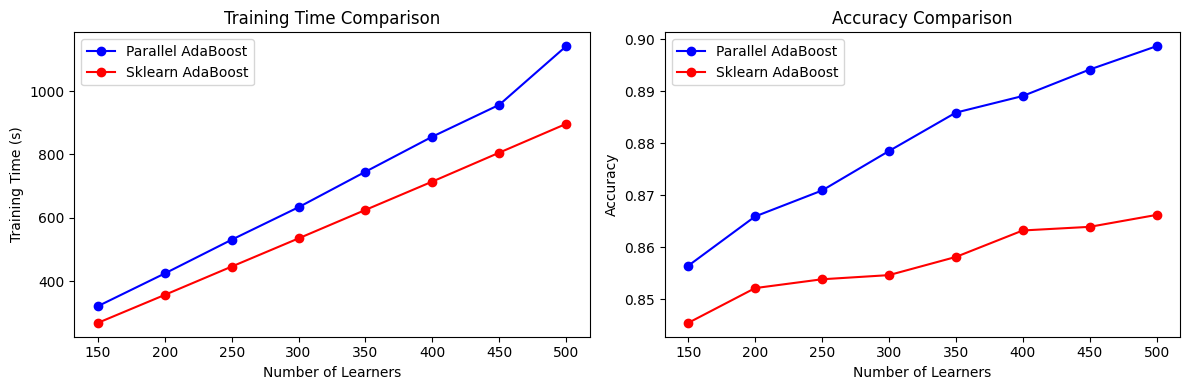

12


In [15]:

# Plot comparisons
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rounds, parallel_times, 'bo-', label='Parallel AdaBoost')
plt.plot(rounds, sklearn_times, 'ro-', label='Sklearn AdaBoost')
plt.title("Training Time Comparison")
plt.xlabel("Number of Learners")
plt.ylabel("Training Time (s)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, acc_parallel, 'bo-', label='Parallel AdaBoost')
plt.plot(rounds, acc_sklearn, 'ro-', label='Sklearn AdaBoost')
plt.title("Accuracy Comparison")
plt.xlabel("Number of Learners")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
print(cpu_count())

c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Admin\Desktop\pdcproj\venv\lib\site-packages\sklearn\ensemble\_weight_boost

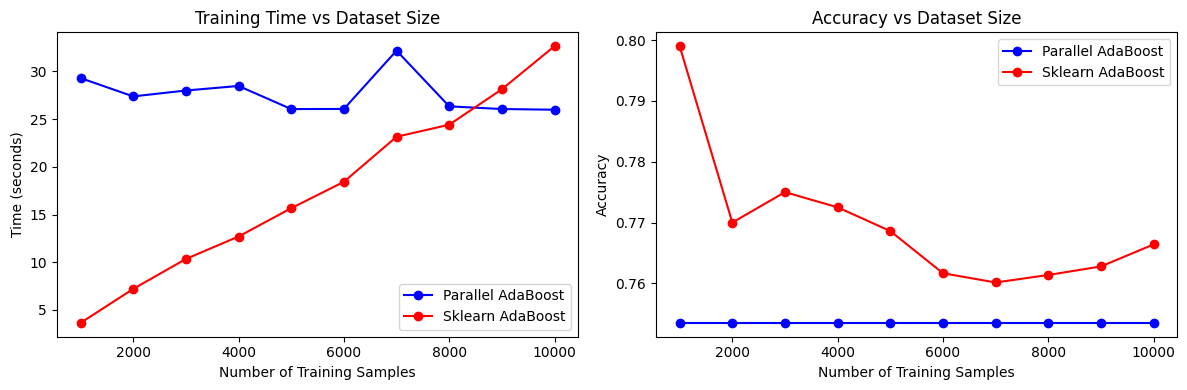

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count
import time

# Initialize lists to store metrics
parallel_times, sklearn_times = [], []
acc_parallel, acc_sklearn = [], []

# Define dataset size increments (10% to 100% of total data)
n_total = X.shape[0]
sample_fracs = np.linspace(0.1, 1.0, 10)
sample_sizes = (n_total * sample_fracs).astype(int)

# Fixed number of estimators
N_ESTIMATORS = 10  

for size in sample_sizes:
    # Subset the data
    X_sub, y_sub = X[:size], y[:size]
    
    # Parallel AdaBoost
    start = time.time()
    parallel_clf = ParallelAdaBoost(n_estimators=N_ESTIMATORS, n_jobs=cpu_count())
    parallel_clf.fit(X, y)
    t_parallel = time.time() - start
    y_pred_parallel = parallel_clf.predict(X)
    acc_p = accuracy_score(y, y_pred_parallel)
    
    # Sklearn AdaBoost
    start = time.time()
    clf = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=N_ESTIMATORS,
        algorithm='SAMME'
    ).fit(X_sub, y_sub)
    t_sklearn = time.time() - start
    acc_s = accuracy_score(y_sub, clf.predict(X_sub))
    
    # Store results
    parallel_times.append(t_parallel)
    sklearn_times.append(t_sklearn)
    acc_parallel.append(acc_p)
    acc_sklearn.append(acc_s)

# Plot results
plt.figure(figsize=(12, 4))

# Training Time Plot
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, parallel_times, 'bo-', label='Parallel AdaBoost')
plt.plot(sample_sizes, sklearn_times, 'ro-', label='Sklearn AdaBoost')
plt.title("Training Time vs Dataset Size")
plt.xlabel("Number of Training Samples")
plt.ylabel("Time (seconds)")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(sample_sizes, acc_parallel, 'bo-', label='Parallel AdaBoost')
plt.plot(sample_sizes, acc_sklearn, 'ro-', label='Sklearn AdaBoost')
plt.title("Accuracy vs Dataset Size")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()